Understanding how NNs understand
======================

In this first post we consider a basic example of classification task. The dataset consists of pictures of football players from three different teams: Atletico de Madrid, Betis and Chelsea.

Both datasets have been downloaded from Google Images using a simple key word search and the Chrome extension "Download All Images". This simple setup will cause some variance on the model since the datasets are not very clean, but it allows us to rapidly train a simple NN and analyze the concepts that the NNs are understanding.

To get a feeling of what these datasets look like, lets load the images:

In [1]:
from data_preparation.data_utils import create_hdf5_file_from_path, load_dataset, gallery
from data_preparation.tf_utils import convert_to_one_hot
import matplotlib.pyplot as plt
import numpy as np

The shape of the traning set is: (783, 112, 112, 3)
The shape of the training labels is: (1, 783)


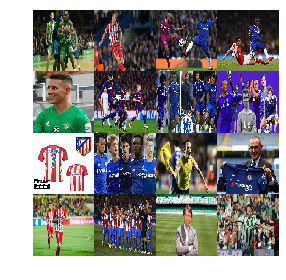

In [2]:
hdf5_path = './images/data_1/data_1.hdf5'

dataset_dictionary = load_dataset(hdf5_path)
X_train_orig = dataset_dictionary["train_set_x_orig"] #_orig points out that they are not vectors yet.
Y_train_orig = dataset_dictionary["train_set_y_orig"]
X_test_orig = dataset_dictionary["test_set_x_orig"]
Y_test_orig = dataset_dictionary["test_set_y_orig"]

print("The shape of the traning set is: " + str(np.shape(X_train_orig)))
print("The shape of the training labels is: " + str(np.shape(Y_train_orig)))

plt.imshow(gallery(X_train_orig, 4))
plt.axis('off')
plt.tight_layout()
plt.show()

Building the Model using Tensorflow
----------------------------
We now build the model using Tensorflow. A nice Tensorflow tutorial can be found in the book "Hands-on Machine Learning with Scikit-Learn and Tensorflow". For simplicity we follow the construction contained in the book.

We first flatten each training set example so that we can feed it into the network. Moreover we make a one-hot conversion of the labels. We have 37.632 inputs and 3 outputs.

In [3]:

# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 3)
Y_test = convert_to_one_hot(Y_test_orig, 3)

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 783
number of test examples = 88
X_train shape: (783, 37632)
Y_train shape: (783, 3)
X_test shape: (88, 37632)
Y_test shape: (88, 3)


Once we have prepared all the data we are ready to build the model. We just have to build a dense layer and then we will apply the softmax function to the output of this layer. We are going to use Tensorflow to do this.

In [4]:
import tensorflow as tf
tf.reset_default_graph()

n_inputs = 112*112*3 # = 37.632
n_outputs = 3

# Define the placeholders for X and Y. Since we are going to train using mini-batches, 
# the shape will not specify the number of examples that we use.

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None, n_outputs), name="y")

# Define the dense layer

logits = tf.layers.dense(X, n_outputs, name="outputs")
    
# Define the loss

xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy, name="loss")

We have defined the model. The next step is to define the optimization algorithm, to initialize the variables and to define the saver to save our model. We use a simple gradient descent optimizer since our model in not complicated.

In [5]:
learning_rate = 0.01

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

As a last step in the construction phase, we set up the way of evaluation the model.

In [6]:
labels = tf.argmax(y, 1)
correct = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

And finally we initialize the variables and the saver.

In [7]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Executing the model
In this part we train the model. We will use a simple mini-match algorithm. Since we want to save some data of our model using the saver, we will uniquelly define the name of the directory we are working on using the date and time.

10 Train accuracy:  0.8429119 Test accuracy:  0.77272725
20 Train accuracy:  0.90676886 Test accuracy:  0.82954544
30 Train accuracy:  0.98978287 Test accuracy:  0.875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40 Train accuracy:  0.9680715 Test accuracy:  0.8068182


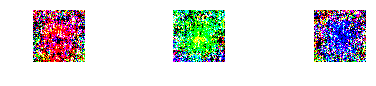

In [8]:
from data_preparation.tf_utils import random_mini_batches # a helper function that divides our training set into minibatches
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 40
minibatch_size = 50
n_examples = X_train.shape[1]

with tf.Session() as sess:
    init.run()
    gr = tf.get_default_graph()
    for epoch in range(n_epochs):
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            sess.run(training_op, feed_dict={X: minibatch_X, y: minibatch_Y})
        if (epoch + 1) % 10 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_train, y: Y_train})
            acc_test = accuracy.eval(feed_dict={X: X_test, y: Y_test})
            print(epoch + 1, "Train accuracy: ", acc_train, "Test accuracy: ", acc_test)
    W = gr.get_tensor_by_name('outputs/kernel:0').eval()
    for i in range(3):
        plt.subplot(n_epochs/10,3,3*(((epoch + 1) / 10)-1) +i+1)
        plt.imshow(255*W[:,i].reshape(112, 112, 3))
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    save_path = saver.save(sess, logdir + "/my_model.ckpt")
            

# Restoring the model
We restore the model and save the value of the parameters W and b.

In [9]:
import tensorflow as tf
from tensorflow.python.framework import ops

ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables

saver = tf.train.import_meta_graph("tf_logs/run-20181030180829/my_model.ckpt.meta")

with tf.Session() as sess:
    saver.restore(sess, "tf_logs/run-20181030180829/my_model.ckpt")
    gr = tf.get_default_graph()
    W = gr.get_tensor_by_name('outputs/kernel:0').eval()
    b = gr.get_tensor_by_name('outputs/bias:0').eval()

INFO:tensorflow:Restoring parameters from tf_logs/run-20181030180829/my_model.ckpt


# Visualizing the Kernels
We transform the weights to RGB arrays and we plot them.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


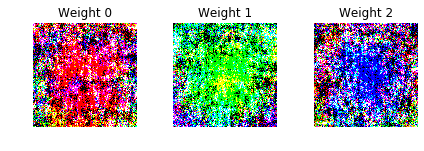

In [10]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(255*W[:,i].reshape(112, 112, 3))
    plt.axis('off')
    plt.title("Weight " + str(i))
plt.tight_layout()
plt.show()

As one can see, the weights have learned to detect the colors of the t-shirts of the players. We now compute the prediction for the weights.

In [12]:
tf.reset_default_graph()

X1 = tf.placeholder(tf.float32, shape=(1,n_inputs), name="X1")
W1 = tf.constant(np.float32(W))
b1 = tf.constant(np.float32(b))
logits3 = tf.add(tf.matmul(X1,W1),b1)
softmax = tf.nn.softmax(logits3)

with tf.Session() as sess:
    print("Prediction for W0: ", softmax.eval(feed_dict={X1 : W[:,0].reshape(1,n_inputs)})[0])   
    print("Prediction for W1: ", softmax.eval(feed_dict={X1 : W[:,1].reshape(1,n_inputs)})[0])   
    print("Prediction for W2: ", softmax.eval(feed_dict={X1 : W[:,2].reshape(1,n_inputs)})[0])  

Prediction for W0:  [9.9784744e-01 4.3308028e-04 1.7194598e-03]
Prediction for W1:  [2.8098468e-04 9.9906248e-01 6.5657159e-04]
Prediction for W2:  [0.00326641 0.00192241 0.9948112 ]


# Maximazing the input with respet to the Kernerls
We use Tensorflow to find the input which maximazes a fixed output.

In [13]:
import matplotlib.pyplot as plt

tf.reset_default_graph()

n_inputs = 112*112*3 # = 37.632
n_outputs = 3

X_init = np.ones((1,n_inputs)) # white initialization
#X_init = np.zeros((1,n_inputs)) # black initialization
#X_init = np.random.randint(255, size=(1,n_inputs))/255 # random initialization
#X_init = X_train[20,:].reshape(1,n_inputs) # morata initialization

X_max = tf.Variable(np.float32(X_init))
W1 = tf.constant(np.float32(W))
b1 = tf.constant(np.float32(b))
label2 = tf.constant(np.float32([1,0,0]))

In [14]:
logits2 = tf.add(tf.matmul(X_max,W1),b1)
loss2 = tf.nn.l2_loss(tf.subtract(label2, tf.nn.softmax(logits2)))

learning_rate2 = 100 
optimizer2 = tf.train.GradientDescentOptimizer(learning_rate2)
training_op2 = optimizer2.minimize(loss2)
init2 = tf.global_variables_initializer()

0 Loss:  0.9851451 Difference:  0.0 Pred:  [[4.3782664e-05 9.8496348e-01 1.4992667e-02]]
100 Loss:  0.99998033 Distance:  5.169602680190349 Pred:  [[9.641139e-06 3.658803e-07 9.999900e-01]]
200 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]
300 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]
400 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]
500 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]
600 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]
700 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]
800 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]
900 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000 Loss:  0.0 Distance:  21.605523169542188 Pred:  [[1.000000e+00 1.410673e-22 5.829859e-30]]


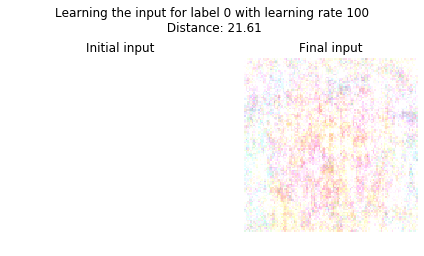

In [15]:
n_epochs = 1000

with tf.Session() as sess:
    init2.run()
    print(0, "Loss: ", loss2.eval(), "Difference: ",np.linalg.norm(X_max.eval()-X_init), "Pred: ", tf.nn.softmax(logits2).eval() )
    for epoch in range(n_epochs):
        sess.run(training_op2)
        if (epoch + 1) % 100 == 0:
            print(epoch + 1, "Loss: ", loss2.eval(), 
                  "Distance: ",np.linalg.norm(X_max.eval()-X_init), 
                  "Pred: ", tf.nn.softmax(logits2).eval() )
    plt.suptitle('Learning the input for label ' + str(np.int_(np.where(label2.eval()==1))[0][0]) + 
                 " with learning rate " + str(learning_rate2) + 
                 "\n Distance: " + str(round(np.linalg.norm(X_max.eval()-X_init),2)))
    plt.subplot(1,2,1)
    plt.imshow(np.int_(255*X_init).reshape(112, 112, 3))
    plt.title("Initial input")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.int_(255*X_max.eval()).reshape(112, 112, 3))
    plt.title("Final input")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

# Maximum activation of the training set
In this last part we find some inputs which have probability one when classified.

In [16]:
tf.reset_default_graph()

X1 = tf.placeholder(tf.float32, shape=(1,n_inputs), name="X1")
W1 = tf.constant(np.float32(W))
b1 = tf.constant(np.float32(b))
logits3 = tf.add(tf.matmul(X1,W1),b1)
softmax = tf.nn.softmax(logits3)

The probability is: 1.0


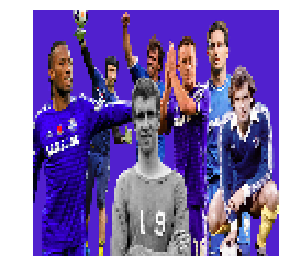

In [17]:
max = 0
label = 2
X_max = None
with tf.Session() as sess:
    for i in range(np.shape(X_train)[0]):
        if softmax.eval(feed_dict={X1 : X_train[i,:].reshape(1,n_inputs)})[0][label] > max:
            max = softmax.eval(feed_dict={X1 : X_train[i,:].reshape(1,n_inputs)})[0][label]
            X_max = X_train[i,:]
    print("The probability is:",max)
    plt.imshow(np.int_(255*X_max).reshape(112, 112, 3))
    plt.tight_layout()
    plt.axis('off')
    plt.show()
    

